In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import requests
import json
import time
import pickle
import copy
import os
from Ames_Functions import *
pd.set_option("display.max_columns", None)

In [ ]:
#os.chdir("") #Change working directory line

In [2]:
df_house2021 = pd.read_csv("df_RE_latlongs_v3_2021.csv", index_col = 0)
df_house2019 = load_state_pkl()["df_RE_latlong2019"][0].set_index("SaleID")
#df_biz = pd.read_csv("df_EssentialLatLong_v2.csv")
#df_min_distances = pd.read_csv("df_min_distances.csv", index_col = 0).set_index("SaleID")
#driv_final_dict = pickle.load(open("df_driv_final.pkl", "rb"))
df_dist_time_all = pd.read_csv("../ML_Project_Sandbox/df_dist_time_all.csv", index_col = 0) #migrate all code to use this dataframe #Needed only for 2021
selected_features_dict = pickle.load(open("../ML_Project_Sandbox/selected_features_dict.pkl", "rb")) #Needed only for 2021

df_feature_all2021 = pd.read_csv("df_feature_all2021.csv", index_col = 0)
df_feature_all2019 = load_state_pkl()["df_house2019_after_feature_engineering"][0] #Dataset ready for regression for 2019

In [3]:
for f in ["Time", "Closest_all_feature", "Closest_5_feature", "Central_historic_feature", "num_biz_180s_feature", "num_biz_480s_feature", "Cars"]:
    display(df_feature_all2021.describe().T.query(f"index == '{f}'")[["mean"]])

mean
Time  146.818799

mean
Closest_all_feature  356.660102

mean
Closest_5_feature  216.309131

mean
Central_historic_feature  395.439652

mean
num_biz_180s_feature  3.227488

mean
num_biz_480s_feature  13.548183

mean
Cars  1.67278

In [4]:
for f in ["Closest_Time", "Convenience_secs", "Closest_5", "Central_historic_feature", "biz_180_secs", "biz_480_secs", "Cars"]:
    display(df_feature_all2019.describe().T.query(f"index == '{f}'")[["mean"]])

#df_feature_all2019.describe().T.query("index == 'Closest_Time'")

mean
Closest_Time  156.280244

mean
Convenience_secs  370.665927

mean
Closest_5  230.535072

mean
Central_historic_feature  411.187791

mean
biz_180_secs  2.940067

mean
biz_480_secs  13.096559

mean
Cars  1.773896

In [5]:
#NOTE: This cell and the next were looking at a special case where house was flipped essentially (Assessor value and SalePrice for 2019 were very different)

#df_house2019.query("TtlVal_AsrYr < 1000")
#df_house2019.query("YrBuilt == 0")[["TtlVal_AsrYr", "SalePrice"]]

#df_house2019.eval("PriceRatio = SalePrice/TtlVal_AsrYr").PriceRatio.sort_values(ascending = False).describe()

display(df_house2019.eval("PriceRatio = SalePrice/TtlVal_AsrYr").query("PriceRatio == PriceRatio.min()")[["PriceRatio", "TtlVal_AsrYr", "SalePrice", "Prop_Addr", "MoSold_MM", "YrBuilt"]])
display(df_house2021[df_house2021.Prop_Addr.str.contains("613 DOTSON")][["SalePrice", "TtlVal_AsrYr", "MoSold_MM"]])

PriceRatio  TtlVal_AsrYr  SalePrice      Prop_Addr  MoSold_MM  YrBuilt
SaleID                                                                        
14581     0.015787        367400     5800.0  613 DOTSON DR       12.0   2020.0

SalePrice  TtlVal_AsrYr  MoSold_MM
SaleID                                    
14580    322000.0        367400        2.0

In [41]:
# def find_important_features (model):
#     return pd.DataFrame(np.array([model.feature_names_in_, model.feature_importances_]).T, columns = ["Name", "Importance"]).sort_values(by = "Importance", ascending = False)

In [42]:
# def EDA_report (dist_data):
#     display(dist_data.describe())
#     num_cols = dist_data.shape[1]
#     num_x_cols = num_cols - 1
#     y_col = dist_data.columns[-1]
#     print("Field correlation with SalePrice")
#     print(dist_data.corr()[y_col].sort_values(ascending = False))
#     print("-"*30)
#     print()
#     X = dist_data.iloc[:, :num_x_cols]
#     y = dist_data[y_col]
#     print("Random Forest Feature Importances")
#     RFR = RandomForestRegressor()
#     RFR.fit(X, y)
#     print(find_important_features(RFR))
#     print("-"*30)
#     print()
#     model = smf.ols(formula = y_col + " ~ " + "+".join(dist_data.columns[:-1].tolist()), data = dist_data).fit()
#     summary = model.summary()
#     print(summary)
#     plt.figure(figsize = (20,20))
#     sns.heatmap(dist_data.corr())
#     return model
    

In [43]:
# #Distance function from one lat long to another
# def get_dist(from_location, to_location):
#     #print("from",from_location)
#     from_loc = from_location * (np.pi)/180
#     #print("to", to_location)
#     to_loc = to_location * np.pi/180
#     delta = from_loc - to_loc
#     phi = (from_loc[0] + to_loc[0])/2
#     #print(from_loc)
#     #print(to_loc)
#     return np.sqrt((np.cos(phi)*delta[1])**2+delta[0]**2)*3963.19

In [44]:
# def OSMR (lat_1, long_1, lat_2, long_2):
#     # call the OSMR API
#     r = requests.get(f"http://router.project-osrm.org/route/v1/car/{long_1},{lat_1};{long_2},{lat_2}?overview=false""")
#     # then you load the response using the json libray
#     # by default you get only one alternative so you access 0-th element of the `routes`
#     routes = json.loads(r.content)
#     route_1 = routes.get("routes")[0]
#     return pd.DataFrame(route_1)[["duration", "distance"]].values

In [45]:
# def get_vif (df):
#     return [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

In [ ]:
# s_SalePrice = df_min_distances.SalePrice

# (df_min_distances
#     .drop("SalePrice", axis = 1)
#     .join(driv_final_dict["from_time"]
#           .drop("SalePrice", axis = 1)
#           .add_suffix("_time")
#           )
#     .join(s_SalePrice)
# )#.to_csv("df_dist_time_all.csv")

In [ ]:
#MOVED TO FEATURE ENGINEERING NOTEBOOK
# df_temp = df_dist_time_all.filter(regex = "time$|SaleID").drop(df_dist_time_all.filter(regex = "house").columns, axis = 1).stack().reset_index().set_axis(["SaleID", "Service", "Time"], axis = 1)


# (pd.get_dummies(
#                         df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
#                         columns = ["Service"]
#                         )
#             .set_index("SaleID")
#             .join(df_dist_time_all.SalePrice)
# )

# #EDA_report(pd.get_dummies(df_temp.drop("SalePrice", axis = 1), columns = ["Service"]).join(df_temp.pop("SalePrice")))

In [ ]:
df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()].Service.value_counts(normalize = True)

In [ ]:
#VIF for driving times
get_vif(pd.get_dummies(
                        df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
                        columns = ["Service"]
                        )
            .set_index("SaleID")
        )

In [ ]:
#VIF for point to point dist
get_vif(pd.get_dummies(df_temp.loc[df_temp.groupby("SaleID").Dist.idxmin()], columns = ["Service"]).set_index("SaleID"))

In [ ]:
EDA_report(pd.get_dummies(
                df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
                columns = ["Service"]
                )
    .set_index("SaleID")
    .join(pd.DataFrame(selected_features_dict))
    .join(df_dist_time_all.SalePrice)
)

In [162]:
get_vif(pd.get_dummies(
                df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
                columns = ["Service"]
                )
    .set_index("SaleID")
    .join(pd.DataFrame(selected_features_dict))
)

[5.268192423028085,
 20.458059093474734,
 141.839283957568,
 15.560523086480124,
 188.74737072310091,
 13.5260437355077,
 9.569809394514744,
 4.4281520946978805,
 23.449158449802564,
 85.49954401139367,
 90.38328993033853,
 61.58293666896477,
 12.210383887685447,
 119.7838214472846,
 125.3574147008679,
 73.04247022526377,
 83.33215947956525,
 39.35797481205091,
 144.490975823461,
 63.82612134920185,
 9.685768846311124,
 21.37406298905848]

In [176]:
df_house.GarageType.value_counts()

Attachd    353
Detachd    166
None        40
No Data     30
BuiltIn     28
Basment     11
Carport      3
2 Types      2
Name: GarageType, dtype: int64

# Creating Master DataFrame with all fields + all feature engineered fields

In [ ]:
# df_feature_all2021 = (pd.get_dummies(
#                 df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
#                 columns = ["Service"]
#                 )
#     .set_index("SaleID")
#     .join(pd.DataFrame(selected_features_dict))
#     .join(df_house2021.filter(regex = "Yr|_Ext|Has|Area|SF|Cars|Fireplaces|GrType|HsStyle").drop(["YrSold_YYYY"], axis = 1))
# )
# #df_feature_all.to_csv("df_feature_all.csv")

In [28]:
#Should have been done earlier in feature engineering (THIS HAS BEEN MOVED TO FEATURE ENGINEERING)
df_feature_all2021 = df_feature_all2021.join(df_house2021.TtlVal_AsrYr)
df_feature_all2021.rename(columns = {col: col.replace(" ", "_").replace("1", "one").replace("2", "two").replace("5", "five") for col in df_feature_all2021.columns}, inplace = True)

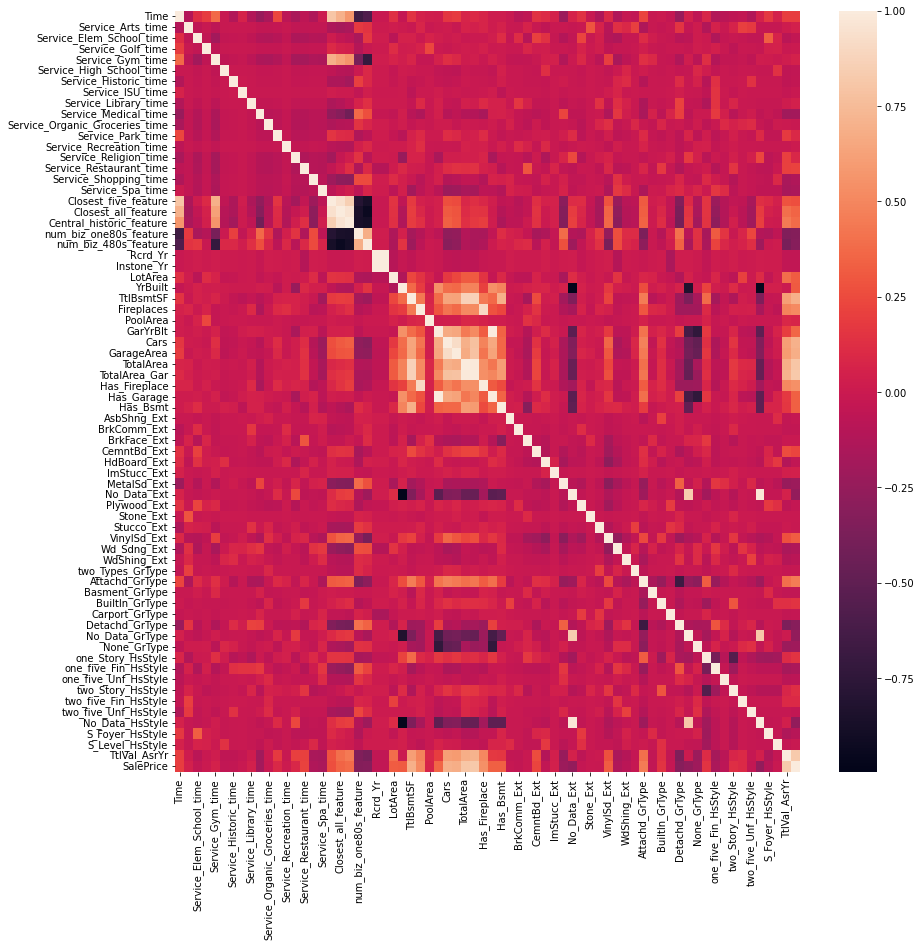

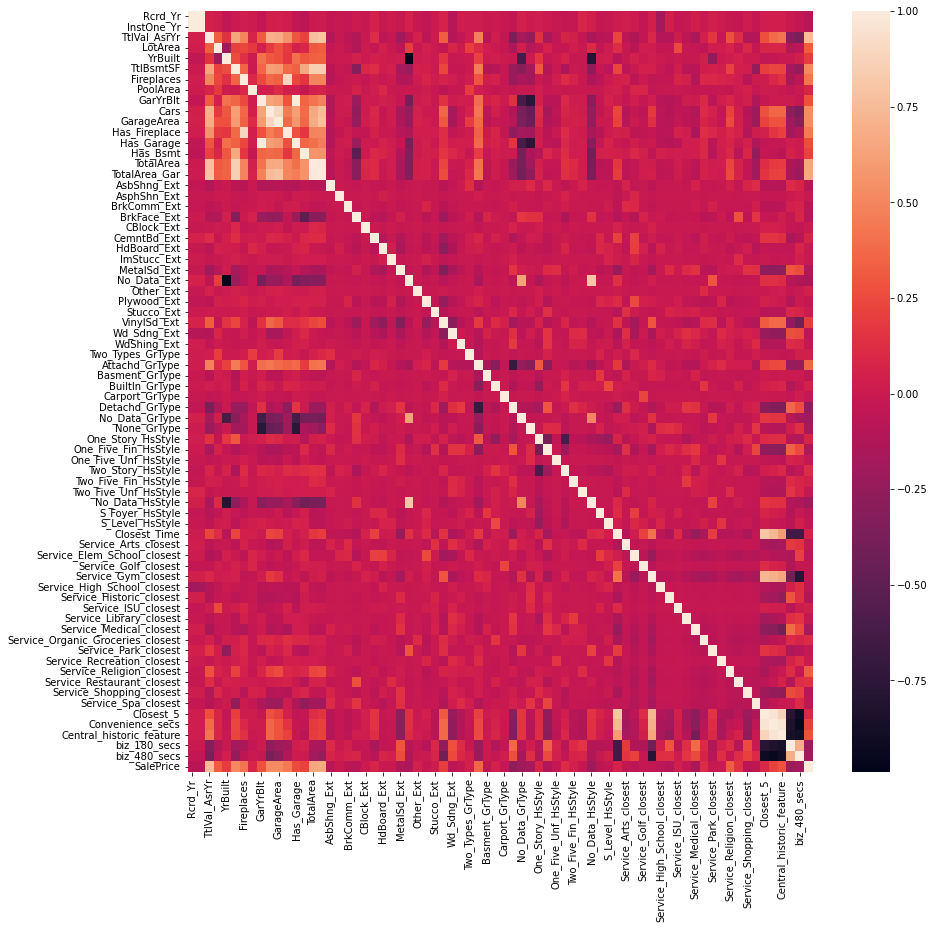

In [31]:
reports2021 = EDA_report(df_feature_all2021.join(df_house2021.SalePrice))
reports2019 = EDA_report(df_feature_all2019.join(df_house2019.SalePrice))

In [33]:
reports2019["corr"].reset_index().join(reports2021["corr"].reset_index(), lsuffix = "_2019", rsuffix = "_2021").head(30)

index_2019  SalePrice_2019  \
0                           SalePrice        1.000000   
1                        TtlVal_AsrYr        0.747653   
2                       TotalArea_Gar        0.656745   
3                           TotalArea        0.645802   
4                          GarageArea        0.520307   
5                                Cars        0.519899   
6                           TtlBsmtSF        0.509157   
7                       Has_Fireplace        0.444714   
8                          Fireplaces        0.423013   
9                      Attachd_GrType        0.359747   
10           Service_Religion_closest        0.316571   
11                            LotArea        0.310644   
12           Central_historic_feature        0.279808   
13                           GarYrBlt        0.276267   
14                         Has_Garage        0.259945   
15                           Has_Bsmt        0.218541   
16                   Convenience_secs        0.208339   
17                        VinylSd_Ext        0.198936   
18                            YrBuilt        0.190646   
19         Service_Restaurant_closest        0.138362   
20                  Two_Story_HsStyle        0.113711   
21  Service_Organic_Groceries_closest        0.109029   
22                          Closest_5        0.095059   
23                           PoolArea        0.079730   
24                  One_Story_HsStyle        0.071957   
25                        CemntBd_Ext        0.068570   
26                       Closest_Time        0.065710   
27                     BuiltIn_GrType        0.056765   
28               Two_Five_Fin_HsStyle        0.046741   
29                          Other_Ext        0.045649   

                  index_2021  SalePrice_2021  
0                  SalePrice        1.000000  
1               TtlVal_AsrYr        0.827797  
2              TotalArea_Gar        0.820323  
3                  TotalArea        0.798409  
4                       Cars        0.701327  
5                  TtlBsmtSF        0.693831  
6                 GarageArea        0.685732  
7              Has_Fireplace        0.547145  
8                 Fireplaces        0.510575  
9             Attachd_GrType        0.450468  
10  Central_historic_feature        0.382961  
11                  GarYrBlt        0.355864  
12       Closest_all_feature        0.345661  
13                  Has_Bsmt        0.337018  
14                Has_Garage        0.336353  
15               VinylSd_Ext        0.316795  
16                   LotArea        0.315978  
17                   YrBuilt        0.308767  
18      Closest_five_feature        0.262897  
19               CemntBd_Ext        0.227719  
20   Service_Restaurant_time        0.215112  
21                      Time        0.190147  
22            BuiltIn_GrType        0.142638  
23         one_Story_HsStyle        0.142510  
24         two_Story_HsStyle        0.120893  
25      two_five_Fin_HsStyle        0.098320  
26         Service_Park_time        0.090913  
27     Service_Religion_time        0.083622  
28                  PoolArea        0.065435  
29          Service_Gym_time        0.055249

In [40]:
reports2019["important_features"].reset_index(drop = True).join(reports2021["important_features"].reset_index(drop = True), lsuffix = "_2019", rsuffix = "_2021").head(30)

Name_2019 Importance_2019                       Name_2021  \
0               TtlVal_AsrYr        0.612343                   TotalArea_Gar   
1                   GarYrBlt        0.078703                    TtlVal_AsrYr   
2                    YrBuilt        0.059405                       TotalArea   
3              TotalArea_Gar        0.059236                         YrBuilt   
4                  TotalArea        0.049438                       TtlBsmtSF   
5                    LotArea        0.021201        Central_historic_feature   
6                    Rcrd_Yr        0.016307                     No_Data_Ext   
7               Closest_Time        0.013777                            Time   
8   Central_historic_feature        0.011584                 No_Data_HsStyle   
9                 InstOne_Yr        0.011136                         LotArea   
10                 TtlBsmtSF        0.010054             Closest_all_feature   
11                GarageArea        0.008443                        GarYrBlt   
12          Convenience_secs        0.007349            Closest_five_feature   
13                 Closest_5        0.006521                      GarageArea   
14       Service_Gym_closest        0.003013            num_biz_480s_feature   
15           No_Data_HsStyle        0.002941                      Has_Garage   
16              biz_480_secs        0.002699          num_biz_one80s_feature   
17               No_Data_Ext        0.002643                            Cars   
18                      Cars        0.002407                     CemntBd_Ext   
19              biz_180_secs        0.002054                      Fireplaces   
20            No_Data_GrType        0.001712            one_five_Fin_HsStyle   
21      Service_Park_closest        0.001464                     Wd_Sdng_Ext   
22  Service_Religion_closest        0.001259  Service_Organic_Groceries_time   
23                Has_Garage        0.001132                  Detachd_GrType   
24               Wd_Sdng_Ext        0.001029                     VinylSd_Ext   
25                  Has_Bsmt        0.000941               two_Story_HsStyle   
26               CemntBd_Ext        0.000819            Service_Library_time   
27               VinylSd_Ext        0.000808               one_Story_HsStyle   
28         One_Story_HsStyle         0.00079                     MetalSd_Ext   
29                Fireplaces        0.000729                   Has_Fireplace   

   Importance_2021  
0         0.499291  
1         0.345812  
2         0.041079  
3         0.014247  
4         0.011576  
5         0.010398  
6         0.010094  
7         0.009255  
8         0.008957  
9         0.008264  
10        0.007586  
11        0.005632  
12        0.004198  
13        0.003542  
14        0.002074  
15        0.001485  
16         0.00135  
17        0.001187  
18        0.001087  
19         0.00105  
20        0.000787  
21        0.000706  
22          0.0007  
23        0.000655  
24        0.000587  
25        0.000502  
26        0.000484  
27        0.000443  
28        0.000427  
29        0.000417

In [55]:
print(reports2021["ols_summary"])

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     48.45
Date:                Sun, 09 Jul 2023   Prob (F-statistic):          2.74e-188
Time:                        11:41:59   Log-Likelihood:                -7693.8
No. Observations:                 633   AIC:                         1.551e+04
Df Residuals:                     570   BIC:                         1.579e+04
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [54]:
print(reports2019["ols_summary"]) #.reset_index(drop = True).join(reports2021["important_features"].reset_index(drop = True), lsuffix = "_2019", rsuffix = "_2021").head(30)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     25.51
Date:                Sun, 09 Jul 2023   Prob (F-statistic):          5.38e-155
Time:                        11:42:00   Log-Likelihood:                -11245.
No. Observations:                 901   AIC:                         2.262e+04
Df Residuals:                     836   BIC:                         2.293e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [67]:
#Taking a look at SalePrice versus Assessor Value of each home for 2019 and 2021

(df_house2019.eval("PriceDiff = abs(SalePrice - TtlVal_AsrYr)").PriceDiff.mean(), 
 df_house2021.eval("PriceDiff = abs(SalePrice - TtlVal_AsrYr)").PriceDiff.mean(),
 df_house2019.eval("PriceRatio = SalePrice/TtlVal_AsrYr").PriceRatio.mean(), 
 df_house2021.eval("PriceRatio = SalePrice/TtlVal_AsrYr").PriceRatio.mean())

#TtlVal_AsrYr field likely updated every time there's an assessment (every odd year) for old records as well. 
#So 2019 records reflect 2021 assessment values that are higher than what they would have been in 2019.

(33587.59600443951, 43168.848341232224, 1.9190268649709301, 1.3348662616524758)

<AxesSubplot:>

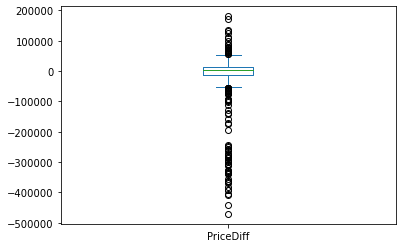

In [70]:
df_house2019.eval("PriceDiff = SalePrice - TtlVal_AsrYr").PriceDiff.plot.box()

<AxesSubplot:>

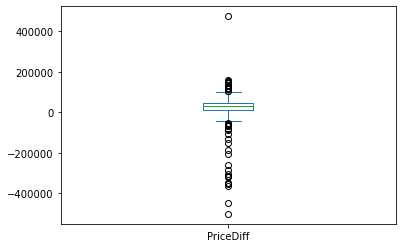

In [71]:
df_house2021.eval("PriceDiff = SalePrice - TtlVal_AsrYr").PriceDiff.plot.box()

In [78]:
#df_house2021.loc[df_house2021.eval("PriceDiff = SalePrice - TtlVal_AsrYr").PriceDiff.idxmin()]
df_house2021.eval("PriceDiff = SalePrice - TtlVal_AsrYr").query("index == 197")[["SalePrice", "TtlVal_AsrYr"]]

SalePrice  TtlVal_AsrYr
SaleID                         
197      115000.0        616700

In [ ]:
df_house2021.merge(df_house2019, on = 'Prop_Addr', suffixes = ["_2021", "_2019"])[["TtlVal_AsrYr_2021", "TtlVal_AsrYr_2019"]].query("TtlVal_AsrYr_2021 == TtlVal_AsrYr_2019")

#[["Prop_Addr_2021", "Prop_Addr_2019"]].query("Prop_Addr_2021 != Prop_Addr_2019")

In [105]:
X_lassoCV_2019, X_lassoCV_2021 = df_feature_all2019, df_feature_all2021
y_lassoCV_2019, y_lassoCV_2021 = df_house2019.SalePrice, df_house2021.SalePrice

In [ ]:
lassoCV_2019, lassoCV_2021 = LassoCV(normalize = True, max_iter = 10000, random_state = 0), LassoCV(normalize = True, max_iter = 10000, random_state = 0)
lassoCV_2019.fit(X_lassoCV_2019, y_lassoCV_2019)
lassoCV_2021.fit(X_lassoCV_2021, y_lassoCV_2021)
lassoCV_2019_cols, lassoCV_2021_cols = lassoCV_2019.feature_names_in_[np.where(lassoCV_2019.coef_ != 0)], lassoCV_2021.feature_names_in_[np.where(lassoCV_2021.coef_ != 0)]

In [128]:
#Taking a look at lassoCV columns vifs
#df_house2019.PoolArea.value_counts()
#display(df_feature_all2019[lassoCV_2019_cols[2:]])
#lassoCV_2019_cols[2:][np.where(np.array(get_vif(df_feature_all2019[lassoCV_2019_cols[2:]])) > 5)[0]]
#lassoCV_2019_cols

0.0      895
648.0      3
800.0      2
576.0      1
Name: PoolArea, dtype: int64

In [ ]:
model_EDA = EDA_report(df_feature_all[lassoCV_cols].join(df_house.SalePrice))

In [269]:
selectLassoCV_cols = lassoCV_cols[np.where((lassoCV_cols != "Cars") & (lassoCV_cols != "Has_Fireplace") & (lassoCV_cols != "LotArea") & (lassoCV_cols != "Has_Bsmt"))]
pd.DataFrame(np.array([get_vif(df_feature_all[selectLassoCV_cols]), selectLassoCV_cols])).T

0                         1
0   1.896207          Service_Gym_time
1   1.106911      Service_Library_time
2   1.409212   Service_Restaurant_time
3   6.879479  Central_historic_feature
4   2.619459                Fireplaces
5    7.58259             TotalArea_Gar
6   1.241459               BrkFace_Ext
7   1.173285               Plywood_Ext
8   2.023203               VinylSd_Ext
9   1.402481            Detachd_GrType
10  1.022862      two_five_Fin_HsStyle
11  1.069504      two_five_Unf_HsStyle

In [286]:
df_feature_all[model_EDA.pvalues[model_EDA.pvalues < 0.05].index]

Service_Gym_time  Service_Library_time  Central_historic_feature  \
SaleID                                                                     
2                      0                     0                     606.4   
3                      0                     0                     606.4   
18                     0                     0                     616.2   
19                     0                     0                     619.4   
20                     0                     0                     622.7   
...                  ...                   ...                       ...   
22743                  0                     0                     391.4   
22749                  0                     0                     420.0   
22756                  0                     0                     438.8   
22768                  0                     0                     439.7   
22888                  0                     0                     345.7   

         LotArea  TotalArea_Gar  Has_Bsmt  BrkFace_Ext  Plywood_Ext  \
SaleID                                                                
2        12493.0            0.0         0            0            0   
3         9595.0         3615.0         1            0            0   
18       13596.0         3730.0         1            0            0   
19       10890.0            0.0         0            0            0   
20       10842.0            0.0         0            0            0   
...          ...            ...       ...          ...          ...   
22743    10776.0         2676.0         1            0            0   
22749    12395.0         2237.0         1            0            1   
22756    10463.0         2347.0         1            0            0   
22768    10457.0         3313.0         1            0            0   
22888   101059.0         2356.0         1            0            0   

        Detachd_GrType  two_five_Fin_HsStyle  
SaleID                                        
2                    0                     0  
3                    0                     0  
18                   0                     0  
19                   0                     0  
20                   0                     0  
...                ...                   ...  
22743                1                     0  
22749                0                     0  
22756                1                     0  
22768                0                     0  
22888                0                     0  

[633 rows x 10 columns]

# Random Forest Section

In [205]:
years = {}
years["2019"] = {"df_feature_all": df_feature_all2019, "df_house": df_house2019}
years["2021"] = {"df_feature_all": df_feature_all2021, "df_house": df_house2021}

for y in years.values():
    y["RFR"] = {"Score": {}}
    y["RFR"]["Model"] = RandomForestRegressor(random_state = 0)
    y["RFR"]["Model"].set_params(n_estimators = 100, min_samples_split = 3, min_samples_leaf = 1, criterion = 'absolute_error') #params from first round of gridsearchCV on 2021 data for RFR
    y["RFR"]["Model"].fit(y["df_feature_all"], y["df_house"].SalePrice)
    y["RFR"]["Score"]["all"] = y["RFR"]["Model"].score(y["df_feature_all"], y["df_house"].SalePrice)

years["2019"]["RFR"]["Score"], years["2021"]["RFR"]["Score"]

({'all': 0.9290529712587692}, {'all': 0.9747509870495054})

In [136]:
# RFR = RandomForestRegressor(random_state = 0)
# # RFR.fit(df_feature_all2021, df_house2021.SalePrice)
# # RFR.score(df_feature_all2021, df_house2021.SalePrice)

0.9761721185276213

In [206]:
for y in years.values():
    y["X"] = {}
    y["y"] = {}
    y["X"]["train"] , y["X"]["test"], y["y"]["train"], y["y"]["test"] = train_test_split(y["df_feature_all"], y["df_house"].SalePrice, test_size = 0.3, random_state = 0)

#X_train, X_test, y_train, y_test = train_test_split(df_feature_all, df_house.SalePrice, test_size = 0.2, random_state = 0)

In [207]:
for i, y in years.items():
    y["RFR"]["Model"].fit(y["X"]["train"], y["y"]["train"])
    y["RFR"]["Score"]["train"] = y["RFR"]["Model"].score(y["X"]["train"], y["y"]["train"]) 
    y["RFR"]["Score"]["test"] = y["RFR"]["Model"].score(y["X"]["test"], y["y"]["test"]) 
    print(i, "train score:", y["RFR"]["Score"]["train"])
    print(i, "test score:", y["RFR"]["Score"]["test"])

2019 train score: 0.9405152864820496
2019 test score: 0.7072817564836282
2021 train score: 0.9728173972371635
2021 test score: 0.8713918260890149


RandomizedSearchCV on Random Forest

In [217]:
params_forest = [{
    "n_estimators": [50, 100, 150, 200],
    "criterion": ['absolute_error'],
    "min_samples_leaf": range(1, 5),
    "min_samples_split": np.linspace(start=2, stop=10, num=10, dtype=int),
    "random_state": [0]}]

grid_search_RF = RandomizedSearchCV(RandomForestRegressor(), params_forest, scoring = 'r2', cv=5, n_jobs=7, verbose = 3, n_iter = 5)
grid_search_RF.fit(years["2019"]["df_feature_all"], years["2019"]["df_house"].SalePrice)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END criterion=absolute_error, min_samples_leaf=2, min_samples_split=4, n_estimators=50, random_state=0;, score=0.684 total time=   4.0s
[CV 2/5] END criterion=absolute_error, min_samples_leaf=2, min_samples_split=4, n_estimators=50, random_state=0;, score=0.832 total time=   4.3s
[CV 3/5] END criterion=absolute_error, min_samples_leaf=2, min_samples_split=4, n_estimators=50, random_state=0;, score=0.845 total time=   3.8s
[CV 4/5] END criterion=absolute_error, min_samples_leaf=2, min_samples_split=4, n_estimators=50, random_state=0;, score=0.567 total time=   4.1s
[CV 5/5] END criterion=absolute_error, min_samples_leaf=2, min_samples_split=4, n_estimators=50, random_state=0;, score=0.826 total time=   3.7s
[CV 1/5] END criterion=absolute_error, min_samples_leaf=3, min_samples_split=2, n_estimators=50, random_state=0;, score=0.683 total time=   3.8s
[CV 4/5] END criterion=absolute_error, min_samples_leaf=2, min_samples

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5, n_jobs=7,
                   param_distributions=[{'criterion': ['absolute_error'],
                                         'min_samples_leaf': range(1, 5),
                                         'min_samples_split': array([ 2,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                         'n_estimators': [50, 100, 150, 200],
                                         'random_state': [0]}],
                   scoring='r2', verbose=3)

In [218]:
grid_search_RF.best_params_, grid_search_RF.best_score_ 


#2021 SECTION:

# Best params and score WITHOUT ASSESSOR:

#({'random_state': 0,
#   'n_estimators': 100,
#   'min_samples_split': 7,
#   'min_samples_leaf': 1,
#   'criterion': 'squared_error'},
#  0.6352291041964238)



# WITH ASSESSOR:

# Best Params and Score:

# ({'random_state': 0,
#   'n_estimators': 100,
#   'min_samples_split': 3,
#   'min_samples_leaf': 1,
#   'criterion': 'absolute_error'},
#  0.7895917088205711)





# 2019 SECTION:


#BEST PARAMS WITH ASSESSOR:

# ({'random_state': 0,
#   'n_estimators': 150,
#   'min_samples_split': 2,
#   'min_samples_leaf': 3,
#   'criterion': 'absolute_error'},
#  0.7575898039655096)



({'random_state': 0,
  'n_estimators': 150,
  'min_samples_split': 2,
  'min_samples_leaf': 3,
  'criterion': 'absolute_error'},
 0.7575898039655096)

In [219]:
grid_search_RF.score(years["2019"]["X"]["test"], years["2019"]["y"]["test"])

0.8889952923034059

In [220]:
find_important_features(grid_search_RF.best_estimator_)

Name Importance
2       TtlVal_AsrYr   0.721491
8           GarYrBlt   0.070024
4            YrBuilt   0.049355
3            LotArea   0.027962
49      Closest_Time   0.012616
..               ...        ...
20        CBlock_Ext        0.0
7           PoolArea        0.0
18       BrkComm_Ext        0.0
17       AsphShn_Ext        0.0
32  Two_Types_GrType        0.0

[71 rows x 2 columns]

In [73]:
best_params = grid_search_RF.best_estimator_.get_params()
RFR.set_params(**best_params)

RandomForestRegressor(criterion='absolute_error', min_samples_split=3,
                      random_state=0)

In [84]:
RFR.fit(X_train, y_train)
RFR.score(X_train, y_train), RFR.score(X_test, y_test)

(0.9746108884081633, 0.8784313702179527)

In [83]:
RFR.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [85]:
find_important_features(RFR).head(10)

Name Importance
24       TtlVal_AsrYr   0.634367
34      TotalArea_Gar    0.10248
33          TotalArea   0.029702
25            LotArea   0.023737
26            YrBuilt   0.021925
27          TtlBsmtSF   0.019165
0                Time   0.017873
32         GarageArea   0.013747
17  Closest_5_feature   0.012869
30           GarYrBlt   0.012536

In [87]:
df_feature_all

Time  Service_Arts_time  Service_Elem_School_time  Service_Golf_time  \
SaleID                                                                          
2        85.5                  0                         0                  0   
3        85.5                  0                         0                  0   
18       95.3                  0                         0                  0   
19       98.5                  0                         0                  0   
20      101.8                  0                         0                  0   
...       ...                ...                       ...                ...   
22743   276.6                  0                         1                  0   
22749   305.2                  0                         1                  0   
22756   324.0                  0                         1                  0   
22768   324.9                  0                         1                  0   
22888   273.6                  0                         0                  0   

        Service_Gym_time  Service_High_School_time  Service_Historic_time  \
SaleID                                                                      
2                      0                         0                      0   
3                      0                         0                      0   
18                     0                         0                      0   
19                     0                         0                      0   
20                     0                         0                      0   
...                  ...                       ...                    ...   
22743                  0                         0                      0   
22749                  0                         0                      0   
22756                  0                         0                      0   
22768                  0                         0                      0   
22888                  0                         0                      0   

        Service_ISU_time  Service_Library_time  Service_Medical_time  \
SaleID                                                                 
2                      0                     0                     0   
3                      0                     0                     0   
18                     0                     0                     0   
19                     0                     0                     0   
20                     0                     0                     0   
...                  ...                   ...                   ...   
22743                  0                     0                     0   
22749                  0                     0                     0   
22756                  0                     0                     0   
22768                  0                     0                     0   
22888                  0                     0                     0   

        Service_Organic_Groceries_time  Service_Park_time  \
SaleID                                                      
2                                    0                  0   
3                                    0                  0   
18                                   0                  0   
19                                   0                  0   
20                                   0                  0   
...                                ...                ...   
22743                                0                  0   
22749                                0                  0   
22756                                0                  0   
22768                                0                  0   
22888                                0                  0   

        Service_Recreation_time  Service_Religion_time  \
SaleID                                                   
2                             0                      1   
3                             0                 

In [86]:
grid_search_RF.score(X_train, y_train), grid_search_RF.score(X_test, y_test)

(0.9742117928163406, 0.9765893228726691)

GridSearchCV on Random Forest

In [104]:
params_forest = [{
    "n_estimators": [50, 100, 150],
    "criterion": ['squared_error', 'absolute_error'],
    "min_samples_leaf": range(1, 5),
    "min_samples_split": [2], #np.linspace(start=2, stop=10, num=10, dtype=int),
    "random_state": [0]}]

grid_search_RF = GridSearchCV(RFR, params_forest, scoring = 'r2', cv=5, n_jobs=-1, verbose = 3)
grid_search_RF.fit(df_feature_all, df_house.SalePrice)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END criterion=squared_error, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0;, score=0.800 total time=   0.3s
[CV 3/5] END criterion=squared_error, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0;, score=0.215 total time=   0.2s
[CV 2/5] END criterion=squared_error, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0;, score=0.808 total time=   0.3s
[CV 4/5] END criterion=squared_error, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0;, score=0.785 total time=   0.3s
[CV 5/5] END criterion=squared_error, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0;, score=0.524 total time=   0.3s
[CV 1/5] END criterion=squared_error, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=0;, score=0.798 total time=   0.5s
[CV 2/5] END criterion=squared_error, min_samples_leaf=1, min_samples_spl

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid=[{'criterion': ['squared_error', 'absolute_error'],
                          'min_samples_leaf': range(1, 5),
                          'min_samples_split': [2],
                          'n_estimators': [50, 100, 150],
                          'random_state': [0]}],
             scoring='r2', verbose=3)

In [105]:
grid_search_RF.best_params_, grid_search_RF.best_score_

({'criterion': 'absolute_error',
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 100,
  'random_state': 0},
 0.6370987186061243)

In [106]:
grid_search_RF.score(X_test, y_test)

0.9168414709517322

## Support Vector Regressor Section

In [32]:
SVR_model = SVR(epsilon = 1e-4, gamma=1)
SVR_model.fit(X_train, y_train)
SVR_model.score(X_train, y_train), SVR_model.score(X_test, y_test)

(-0.04941923148971483, -0.012640893739327641)

In [30]:
SS = StandardScaler().fit(df_feature_all.filter(regex = "Area|SF|TtlVal|Time|Central_historic_feature"))
X_trainSS = SS.transform(X_train.filter(regex = "Area|SF|TtlVal|Time|Central_historic_feature"))
X_testSS = SS.transform(X_test.filter(regex = "Area|SF|TtlVal|Time|Central_historic_feature"))

In [35]:
SVR_model.fit(X_trainSS, y_train)
SVR_model.score(X_trainSS, y_train), SVR_model.score(X_testSS, y_test)

(0.7418894008281418, 0.7352245186826292)

RandomizedSearchCV on SVR

In [34]:
SVR_model.set_params(kernel = "linear", C = 221315789.47368422, epsilon = 8.947369473684211e-05)

SVR(C=221315789.47368422, epsilon=8.947369473684211e-05, gamma=1,
    kernel='linear')

In [36]:
best_params = []
best_score = []

for i in range(1):
    print(i)
    params = {
        #'kernel' : ['linear'],
        'C' : np.linspace(1e6, 3e8, 20),
        #'gamma' : np.linspace(1e-15, 1e4, 20),
        'epsilon': np.linspace(1e-10, 1e-4, 20)
    }
    randgrid = RandomizedSearchCV(SVR_model, params, cv = 3, return_train_score = True, n_jobs = -1, verbose = 3, n_iter = 10)
    randgrid.fit(X_trainSS, y_train)
    best_params.append(randgrid.best_params_)
    best_score.append(randgrid.best_score_)

0
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END C=16736842.105263159, epsilon=3.684216842105264e-05;, score=(train=0.660, test=0.892) total time=   1.3s
[CV 2/3] END C=16736842.105263159, epsilon=3.684216842105264e-05;, score=(train=0.793, test=0.562) total time=   2.4s
[CV 3/3] END C=16736842.105263159, epsilon=3.684216842105264e-05;, score=(train=0.767, test=0.679) total time=   3.7s
[CV 3/3] END C=126894736.84210527, epsilon=8.421054210526317e-05;, score=(train=0.767, test=0.679) total time=  12.6s
[CV 2/3] END C=126894736.84210527, epsilon=8.421054210526317e-05;, score=(train=0.793, test=0.563) total time=  17.5s
[CV 1/3] END C=300000000.0, epsilon=3.157901578947369e-05;, score=(train=0.661, test=0.892) total time=  22.2s
[CV 2/3] END C=300000000.0, epsilon=3.157901578947369e-05;, score=(train=0.793, test=0.564) total time=  25.4s
[CV 2/3] END C=252789473.68421054, epsilon=7.368423684210528e-05;, score=(train=0.793, test=0.563) total time=  22.6s
[CV 1/3

In [37]:
best_params, best_score #best we got with X_trainSS params: ([{'epsilon': 8.947369473684211e-05, 'C': 221315789.47368422}], score: [0.6512524018396496])


([{'epsilon': 3.157901578947369e-05, 'C': 300000000.0}], [0.7115883350105673])

In [68]:
SVR_model.fit(X_trainSS, y_train)
SVR_model.score(X_testSS, y_test)

0.7164253807494236

GridSearchCV on SVR

In [46]:
params = {
    'kernel' : ['rbf', 'linear'],
    'C' : np.linspace(1e-4, 1e7, 20),
    'gamma' : np.linspace(1e-15, 1e4, 20),
    'epsilon': np.linspace(1e-8, 1e6, 20)
}

grid = GridSearchCV(SVR_model, params, cv = 10, return_train_score = True, n_jobs = -1, verbose = 3)
ans_SVR = grid.fit(X_trainSS, y_train)

Fitting 10 folds for each of 16000 candidates, totalling 160000 fits
[CV 4/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=rbf;, score=(train=-0.044, test=-0.001) total time=   0.0s
[CV 3/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=rbf;, score=(train=-0.049, test=-0.065) total time=   0.0s
[CV 6/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=rbf;, score=(train=-0.049, test=-0.003) total time=   0.0s
[CV 2/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=rbf;, score=(train=-0.044, test=-0.011) total time=   0.0s
[CV 5/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=rbf;, score=(train=-0.046, test=-0.201) total time=   0.0s
[CV 1/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=rbf;, score=(train=-0.048, test=-0.092) total time=   0.0s
[CV 2/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=linear;, score=(train=-0.044, test=-0.011) total time=   0.0s
[CV 3/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=linear;, score=(train=-0.049, test=-0.065) 

KeyboardInterrupt: 

In [112]:
ans_SVR.score(X_testSS, y_test)

0.00218313059514752

In [86]:
#ans_SVR_rbf = copy.deepcopy(ans_SVR)

In [45]:
#ans_SVR_linear= copy.deepcopy(ans_SVR)